In [1]:
"""
This notebook is the lower bound that we need to beat for LPIPS.
"""

'\nThis notebook is the lower bound that we need to beat for LPIPS.\n'

In [6]:
import json
import os
import sys
import numpy as np
sys.path.append(os.path.abspath("../../.."))   # one level up from notebook/
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from data.utils.dataloaders import ReconstructionDataset_Heuristic
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader

In [22]:
def prepare_reconstruction_dataset(reconst_loss_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_losses.json",
                                   LID_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/flextok_based/original_images/val/t_0.64/lid_0000_0329.json",
                                   best_LID_noise_level=[26,26,25,25,24,24,23,14,14],
                                   local_density_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/original_val/unconditional/combined.json",
                                   k_values = [1,2,4,8,16,32,64,128,256],
                                   lpips_variance_file="/BS/data_mani_compress/work/thesis/thesis/data/datasets/LPIPS_variance_reconstructions/val/reconst_"):
    
    """
    Read the reconstruction loss file, LID values for best noise levels, and local density information.
    Create and return a ReconstructionDataset_Heuristic instance.
    """
    if reconst_loss_file != None:
        # read reconstruction loss json file 
        with open(reconst_loss_file, 'r') as f:
            reconst_losses = json.load(f)
    else:
        reconst_losses = None

    if LID_file != None:
        # read LID values for best noise levels
        best_lids_per_k = {}
        for best_lid, k in zip(best_LID_noise_level, k_values):
            with open(LID_file, 'r') as f:
                lid_values = json.load(f)
            paired = [lid_values[i:i+2] for i in range(0, len(lid_values), 2)]
            best_lids_per_k[k] = paired
    else:
        best_lids_per_k = None

    if local_density_file != None:
        # load densities
        density_dict = {}
        for k in k_values:
            with open(local_density_file, 'r') as f:
                current_densities = json.load(f)
            density_dict[k]=current_densities

        processed_density_dict = {}
        timestep_needed = [0,0,0,0,0,0,0,0,0]
        for idx, (key, value) in enumerate(density_dict.items()):
            processed_density_dict[key] = [sum(v[0][timestep_needed[idx]:]) for v in value]
    else:
        processed_density_dict = None

    if lpips_variance_file != None:
        # lpips variance information
        list_lpips_variances = {}
        k_values = [1,2,4,8,16,32,64,128,256]
        for k in k_values:
            with open(f"{lpips_variance_file}{k}.json") as f:
                k_variance = json.load(f)
                list_lpips_variances[k] = [v for inner in k_variance.values() for v in inner.values()]
    else:
        list_lpips_variances = None

    # create dataset
    ds = ReconstructionDataset_Heuristic(
        reconstruction_data=reconst_losses,  # or your processed list of dicts
        local_density_information=processed_density_dict, # [l[0] for l in density]
        lid_information=best_lids_per_k,
        error_key=["LPIPS"],
        lpips_variance_information=list_lpips_variances
    )

    return ds

In [19]:
ds_val = prepare_reconstruction_dataset(lpips_variance_file=None)

ds_val_loader = DataLoader(ds_val, batch_size=32)

In [5]:
print(ds_val[0])
print(type(ds_val[0]['k_value']))

{'LPIPS': 0.6646087765693665, 'k_value': 1, 'image_id': 0, 'lid': [19562.119140625, 7954.99072265625], 'local_density': 23308.985885620117}
<class 'int'>


In [12]:
k_values = [1, 2, 4, 8, 16, 32, 64, 128, 256]


In [23]:
heuristic_lid_density_results = {}
for k in k_values:
    densities = []
    lids = []
    y = []
    for dp in ds_val:
        if dp["k_value"] == k:
            y.append(dp["LPIPS"])
            densities.append(dp["local_density"])
            lids.append(dp["lid"][0])
            
    if len(y) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(y))
        continue

    y = np.array(y)

    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.stack([lids], axis=1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_lid_density_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

k=1: Heuristic method  MAE=0.0451, R²=0.002
k=2: Heuristic method  MAE=0.0487, R²=0.019
k=4: Heuristic method  MAE=0.0530, R²=0.105
k=8: Heuristic method  MAE=0.0552, R²=0.142
k=16: Heuristic method  MAE=0.0560, R²=0.205
k=32: Heuristic method  MAE=0.0540, R²=0.294
k=64: Heuristic method  MAE=0.0504, R²=0.392
k=128: Heuristic method  MAE=0.0434, R²=0.518
k=256: Heuristic method  MAE=0.0357, R²=0.636


In [70]:
heuristic_lid_density_results = {}
for k in k_values:
    densities = []
    lids = []
    y = []
    for dp in ds_val:
        if dp["k_value"] == k:
            y.append(dp["LPIPS"])
            densities.append(dp["local_density"])
            lids.append(dp["lid"][0])  # sum of both lids
            
    if len(y) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(y))
        continue

    y = np.array(y)

    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.stack([densities, lids], axis=1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)

    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_lid_density_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

k=1: Heuristic method  MAE=0.0450, R²=0.005
k=2: Heuristic method  MAE=0.0478, R²=0.053
k=4: Heuristic method  MAE=0.0502, R²=0.184
k=8: Heuristic method  MAE=0.0521, R²=0.225
k=16: Heuristic method  MAE=0.0528, R²=0.282
k=32: Heuristic method  MAE=0.0510, R²=0.358
k=64: Heuristic method  MAE=0.0478, R²=0.441
k=128: Heuristic method  MAE=0.0418, R²=0.548
k=256: Heuristic method  MAE=0.0345, R²=0.658


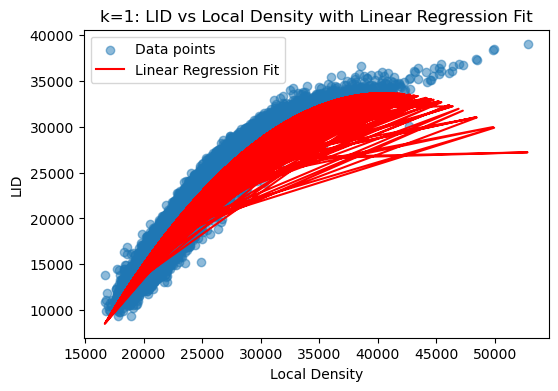

k=1: Heuristic method  MAE=764.7246, R²=0.951


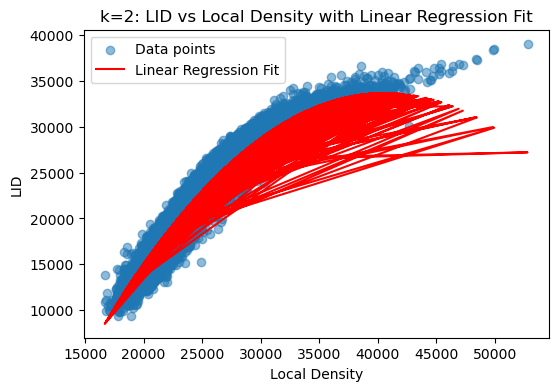

k=2: Heuristic method  MAE=764.7246, R²=0.951


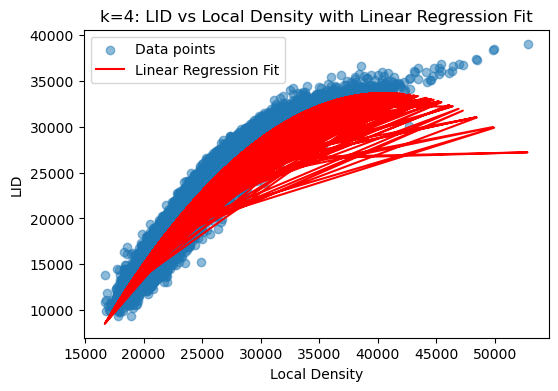

k=4: Heuristic method  MAE=764.7246, R²=0.951


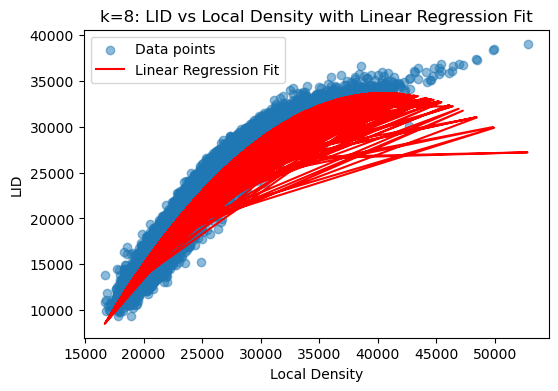

k=8: Heuristic method  MAE=764.7246, R²=0.951


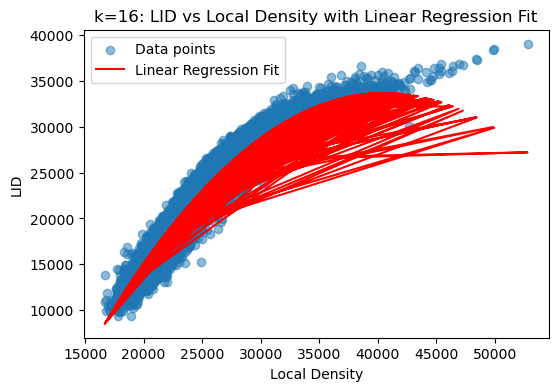

k=16: Heuristic method  MAE=764.7246, R²=0.951


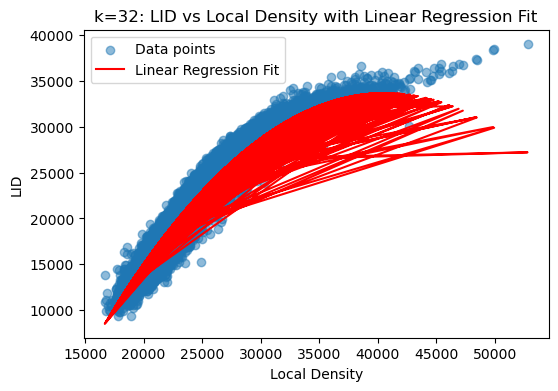

k=32: Heuristic method  MAE=764.7246, R²=0.951


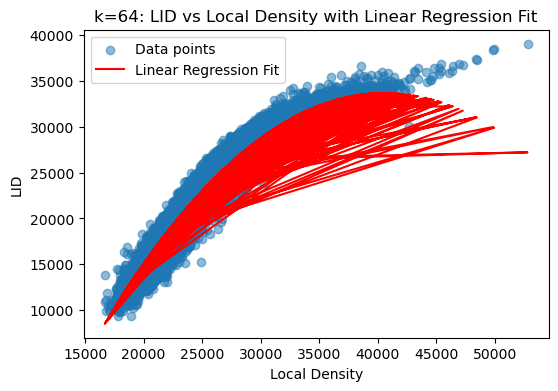

k=64: Heuristic method  MAE=764.7246, R²=0.951


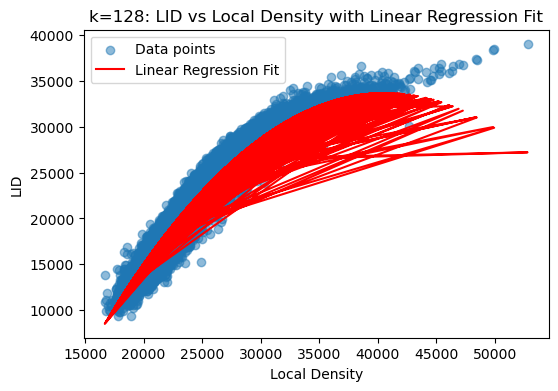

k=128: Heuristic method  MAE=764.7246, R²=0.951


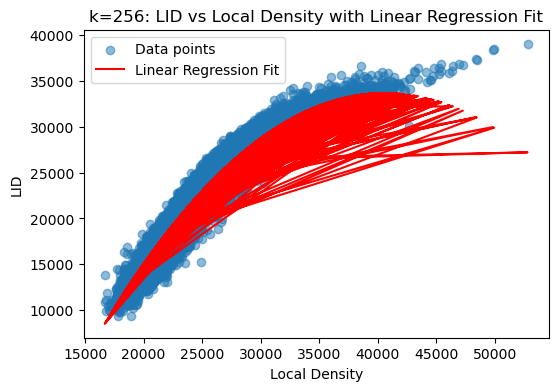

k=256: Heuristic method  MAE=764.7246, R²=0.951


In [71]:
heuristic_lid_density_results = {}
for k in k_values:
    densities = []
    lids = []
    y = []
    for dp in ds_val:
        if dp["k_value"] == k:
            #y.append(dp["LPIPS"])
            densities.append(dp["local_density"])
            lids.append(dp["lid"][0])  # sum of both lids
            
    if len(lids) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(lids))
        continue

    #y = np.array(y)
    y = np.array(lids)
    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.stack([densities], axis=1)
    d = np.array(densities)
    X = np.column_stack([d, d**2])
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)

    # plot x and y
    plt.figure(figsize=(6,4))
    plt.scatter(densities, lids, alpha=0.5, label='Data points')
    plt.plot(densities, y_pred, color='red', label='Linear Regression Fit')
    plt.xlabel('Local Density')
    plt.ylabel('LID')
    plt.title(f'k={k}: LID vs Local Density with Linear Regression Fit')
    plt.legend()
    plt.show()

    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_lid_density_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

In [72]:
heuristic_lid_density_results = {}
for k in k_values:
    densities = []
    lids = []
    y = []
    for dp in ds_val:
        if dp["k_value"] == k:
            y.append(dp["LPIPS"])
            densities.append(dp["local_density"])
            lids.append(dp["lid"][0])
            
    if len(y) < 5:
        print(f"Skipping k={k} due to insufficient data points.", len(y))
        continue

    y = np.array(y)

    # -------------------------
    # Model: linear regression
    # -------------------------
    X = np.stack([densities], axis=1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)

    
    mae_model  = mean_absolute_error(y, y_pred)
    r2 = model.score(X, y)
    heuristic_lid_density_results[k] = mae_model
    print(
        f"k={k}: Heuristic method  MAE={mae_model:.4f}, R²={r2:.3f}"
    )

k=1: Heuristic method  MAE=0.0451, R²=0.003
k=2: Heuristic method  MAE=0.0485, R²=0.032
k=4: Heuristic method  MAE=0.0519, R²=0.149
k=8: Heuristic method  MAE=0.0539, R²=0.190
k=16: Heuristic method  MAE=0.0543, R²=0.257
k=32: Heuristic method  MAE=0.0519, R²=0.345
k=64: Heuristic method  MAE=0.0482, R²=0.438
k=128: Heuristic method  MAE=0.0418, R²=0.547
k=256: Heuristic method  MAE=0.0353, R²=0.642


In [74]:
# find how much common information is there between local density and LID in predicting LPIPS
